# EDA credit_card_balance
In this analysis, we explore the credit card balance data of Home Credit customers to identify the distinct usage patterns between defaulters and non-defaulters. The findings show that defaulters tend to borrow larger amounts of credit and often delay their payments to the later months, which eventually hampers their ability to repay on time. In contrast, non-defaulters generally maintain consistent payment habits, avoiding the tendency to defer payments until the final months.


In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Read files

In [ ]:
cc_bal = pd.read_csv(r'...\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_credit_card_balance.csv')

In [ ]:
train = pd.read_csv(r'...\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv')

# Basic analyzing

In [4]:
print(f'The shape of credit_card_balance.csv is: {cc_bal.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(cc_bal.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(cc_bal.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(cc_bal.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Number of duplicate values in credit_card_balance: {cc_bal.shape[0] - cc_bal.duplicated().shape[0]}')
print('-'*100)
display(cc_bal.head(5))

The shape of credit_card_balance.csv is: (3227965, 23)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 87452
Number of unique SK_ID_CURR in credit_card_balance.csv are: 86905
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 69536
----------------------------------------------------------------------------------------------------
Number of duplicate values in credit_card_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.0,2250.0,...,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0,87788
1,2582071,-82,16809.210,67500,0.0,0.0,0.0,0.0,3375.0,9000.0,...,16809.210,0.0,0,0.0,0.0,18.0,Active,0,0,87788
2,2582071,-84,27577.890,67500,0.0,0.0,0.0,0.0,3375.0,4500.0,...,27577.890,0.0,0,0.0,0.0,16.0,Active,0,0,87788
3,2582071,-7,65159.235,45000,0.0,0.0,0.0,0.0,2250.0,2250.0,...,65609.235,0.0,0,0.0,0.0,63.0,Active,0,0,87788
4,2582071,-59,70475.850,67500,24750.0,24750.0,0.0,0.0,3375.0,4500.0,...,70475.850,4.0,4,0.0,0.0,41.0,Active,0,0,87788


- Out of these 87.4k there are 86.9k unique SK_ID_CURR. What this means is that most of the applicants had just 1 credit card with them, and only few of them had more than 1.

In [5]:
cc_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227965 entries, 0 to 3227964
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   MONTHS_BALANCE              int64  
 2   AMT_BALANCE                 float64
 3   AMT_CREDIT_LIMIT_ACTUAL     int64  
 4   AMT_DRAWINGS_ATM_CURRENT    float64
 5   AMT_DRAWINGS_CURRENT        float64
 6   AMT_DRAWINGS_OTHER_CURRENT  float64
 7   AMT_DRAWINGS_POS_CURRENT    float64
 8   AMT_INST_MIN_REGULARITY     float64
 9   AMT_PAYMENT_CURRENT         float64
 10  AMT_PAYMENT_TOTAL_CURRENT   float64
 11  AMT_RECEIVABLE_PRINCIPAL    float64
 12  AMT_RECIVABLE               float64
 13  AMT_TOTAL_RECEIVABLE        float64
 14  CNT_DRAWINGS_ATM_CURRENT    float64
 15  CNT_DRAWINGS_CURRENT        int64  
 16  CNT_DRAWINGS_OTHER_CURRENT  float64
 17  CNT_DRAWINGS_POS_CURRENT    float64
 18  CNT_INSTALMENT_MATURE_CUM   float64
 19  NAME_CONTRACT_STATUS 

In [6]:
cc_bal.describe()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,SK_ID_CURR
count,3.227965e+06,3.227965e+06,3.227965e+06,3.227965e+06,2.622211e+06,3.227965e+06,2.622211e+06,2.622211e+06,2.963581e+06,2.607872e+06,...,3.227965e+06,3.227965e+06,2.622211e+06,3.227965e+06,2.622211e+06,2.622211e+06,2.963581e+06,3.227965e+06,3.227965e+06,3.227965e+06
mean,1.903894e+06,-3.471544e+01,5.907332e+04,1.529536e+05,6.024272e+03,7.494084e+03,2.984882e+02,2.884152e+03,3.599681e+03,1.023861e+04,...,5.886264e+04,5.887259e+04,3.150212e-01,7.011439e-01,4.988538e-03,5.431047e-01,2.108883e+01,9.494803e+00,2.857060e-01,1.536542e+05
std,5.367415e+05,2.663609e+01,1.066137e+05,1.637092e+05,2.842116e+04,3.396743e+04,8.396193e+03,2.038833e+04,5.611742e+03,3.586433e+04,...,1.062747e+05,1.062813e+05,1.112726e+00,3.171833e+00,8.408493e-02,3.193040e+00,1.998730e+01,9.805148e+01,1.957034e+01,8.857121e+04
min,1.000018e+06,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.431613e+06,-5.600000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.557000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,7.690500e+04
50%,1.896076e+06,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.923020e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,0.000000e+00,1.532070e+05
75%,2.369259e+06,-1.100000e+01,9.040554e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.750000e+03,9.000000e+03,...,9.020840e+04,9.022635e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+01,0.000000e+00,0.000000e+00,2.300480e+05
max,2.843493e+06,-1.000000e+00,1.354829e+06,1.350000e+06,2.115000e+06,2.115000e+06,1.529847e+06,2.060030e+06,2.028820e+05,4.289207e+06,...,1.354829e+06,1.354829e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,2.831000e+03,2.800000e+03,3.075090e+05


- AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_CURRENT, AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE	have min <0 -> check reason

In [7]:
cc_bal[cc_bal['AMT_DRAWINGS_CURRENT'] < 0]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
739495,2340075,-73,1718.1,180000,0.0,-519.57,0.0,0.0,9000.00,182340.000,...,0.0,0.0,0,0.0,0.0,18.0,Active,0,0,97301
929338,2592574,-96,0.0,270000,0.0,-6211.62,0.0,0.0,192.33,14672.205,...,0.0,0.0,0,0.0,0.0,7.0,Active,0,0,33858


In [8]:
cc_bal[cc_bal['AMT_DRAWINGS_ATM_CURRENT'] < 0]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
1990734,1793522,-20,0.0,0,-6827.31,0.0,0.0,0.0,2102.31,2172.69,...,0.0,1.0,1,0.0,0.0,60.0,Active,0,0,71513


In [9]:
cc_bal[cc_bal['AMT_RECEIVABLE_PRINCIPAL'] < 0]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
8163,2196685,-45,-453.690,382500,0.0,0.00,0.0,0.00,10039.500,207000.000,...,-453.690,0.0,0,0.0,0.0,4.0,Active,0,0,144420
12375,1956396,-44,-108.675,247500,0.0,0.00,0.0,0.00,12945.060,267750.000,...,156.825,0.0,0,0.0,0.0,1.0,Active,0,0,131373
13010,2362980,-46,-36885.375,157500,0.0,55767.24,0.0,55767.24,2250.000,47250.000,...,-36885.375,0.0,12,0.0,12.0,1.0,Active,0,0,69311
13408,2787738,-42,-33.840,225000,2250.0,2250.00,0.0,0.00,11250.000,19305.000,...,321.660,1.0,1,0.0,0.0,1.0,Active,0,0,36656
15319,2328055,-45,-697.860,202500,0.0,0.00,0.0,0.00,21.735,719.595,...,-697.860,0.0,0,0.0,0.0,17.0,Active,0,0,261248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054235,1335641,-41,-19.935,225000,0.0,0.00,0.0,0.00,10240.065,10260.000,...,411.120,0.0,0,0.0,0.0,1.0,Active,0,0,25592
3054249,1335641,-40,-19.935,225000,0.0,0.00,0.0,0.00,0.000,19.935,...,-19.935,0.0,0,0.0,0.0,1.0,Active,0,0,25592
3054250,1335641,-38,-19.935,225000,0.0,0.00,0.0,0.00,0.000,19.935,...,-19.935,0.0,0,0.0,0.0,1.0,Active,0,0,25592
3090461,1159593,-39,-19.350,135000,0.0,0.00,0.0,0.00,0.000,19.350,...,-19.350,0.0,0,0.0,0.0,1.0,Active,0,0,271153


In [10]:
cc_bal[cc_bal['AMT_RECIVABLE'] < 0]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
50,2582071,-42,490.500,67500,0.0,0.0,0.0,0.0,3375.000,40410.000,...,-131.355,0.0,0,0.0,0.0,58.0,Active,0,0,87788
61,2582071,-41,67.500,67500,0.0,0.0,0.0,0.0,490.500,621.855,...,-63.855,0.0,0,0.0,0.0,59.0,Active,0,0,87788
1070,2293769,-45,818.595,180000,0.0,0.0,0.0,0.0,10800.000,41580.000,...,-157.725,0.0,0,0.0,0.0,53.0,Active,0,0,174803
1102,2293769,-44,0.000,180000,0.0,0.0,0.0,0.0,818.595,976.320,...,-157.725,0.0,0,0.0,0.0,54.0,Active,0,0,174803
1287,1661600,-45,0.000,0,0.0,0.0,0.0,0.0,0.000,30.735,...,-30.735,0.0,0,0.0,0.0,21.0,Active,0,0,256461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074527,1496949,-42,0.000,0,0.0,0.0,0.0,0.0,0.000,3.420,...,-3.420,0.0,0,0.0,0.0,2.0,Active,0,0,159462
3074529,1496949,-39,0.000,0,0.0,0.0,0.0,0.0,0.000,3.420,...,-3.420,0.0,0,0.0,0.0,2.0,Active,0,0,159462
3074536,1496949,-38,0.000,0,0.0,0.0,0.0,0.0,0.000,3.420,...,-3.420,0.0,0,0.0,0.0,2.0,Active,0,0,159462
3090461,1159593,-39,-19.350,135000,0.0,0.0,0.0,0.0,0.000,19.350,...,-19.350,0.0,0,0.0,0.0,1.0,Active,0,0,271153


In [11]:
cc_bal[cc_bal['AMT_TOTAL_RECEIVABLE'] < 0]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
50,2582071,-42,490.500,67500,0.0,0.0,0.0,0.0,3375.000,40410.000,...,-131.355,0.0,0,0.0,0.0,58.0,Active,0,0,87788
61,2582071,-41,67.500,67500,0.0,0.0,0.0,0.0,490.500,621.855,...,-63.855,0.0,0,0.0,0.0,59.0,Active,0,0,87788
1070,2293769,-45,818.595,180000,0.0,0.0,0.0,0.0,10800.000,41580.000,...,-157.725,0.0,0,0.0,0.0,53.0,Active,0,0,174803
1102,2293769,-44,0.000,180000,0.0,0.0,0.0,0.0,818.595,976.320,...,-157.725,0.0,0,0.0,0.0,54.0,Active,0,0,174803
1287,1661600,-45,0.000,0,0.0,0.0,0.0,0.0,0.000,30.735,...,-30.735,0.0,0,0.0,0.0,21.0,Active,0,0,256461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3074527,1496949,-42,0.000,0,0.0,0.0,0.0,0.0,0.000,3.420,...,-3.420,0.0,0,0.0,0.0,2.0,Active,0,0,159462
3074529,1496949,-39,0.000,0,0.0,0.0,0.0,0.0,0.000,3.420,...,-3.420,0.0,0,0.0,0.0,2.0,Active,0,0,159462
3074536,1496949,-38,0.000,0,0.0,0.0,0.0,0.0,0.000,3.420,...,-3.420,0.0,0,0.0,0.0,2.0,Active,0,0,159462
3090461,1159593,-39,-19.350,135000,0.0,0.0,0.0,0.0,0.000,19.350,...,-19.350,0.0,0,0.0,0.0,1.0,Active,0,0,271153


# Checking missing values

In [12]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [13]:
cc_bal.isna().sum()

SK_ID_PREV                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      605754
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    605754
AMT_DRAWINGS_POS_CURRENT      605754
AMT_INST_MIN_REGULARITY       264384
AMT_PAYMENT_CURRENT           620093
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      605754
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    605754
CNT_DRAWINGS_POS_CURRENT      605754
CNT_INSTALMENT_MATURE_CUM     264384
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
SK_ID_CURR                         0
dtype: int64

In [14]:
print('-'*100)
print("Columns with NaN values and their percentages:")
credit_card_nan = nan_df_create(cc_bal)
display(credit_card_nan[credit_card_nan.percent != 0])
print('-'*100)
del credit_card_nan


----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
9,AMT_PAYMENT_CURRENT,19.210029
14,CNT_DRAWINGS_ATM_CURRENT,18.765817
4,AMT_DRAWINGS_ATM_CURRENT,18.765817
6,AMT_DRAWINGS_OTHER_CURRENT,18.765817
7,AMT_DRAWINGS_POS_CURRENT,18.765817
17,CNT_DRAWINGS_POS_CURRENT,18.765817
16,CNT_DRAWINGS_OTHER_CURRENT,18.765817
8,AMT_INST_MIN_REGULARITY,8.190423
18,CNT_INSTALMENT_MATURE_CUM,8.190423


----------------------------------------------------------------------------------------------------


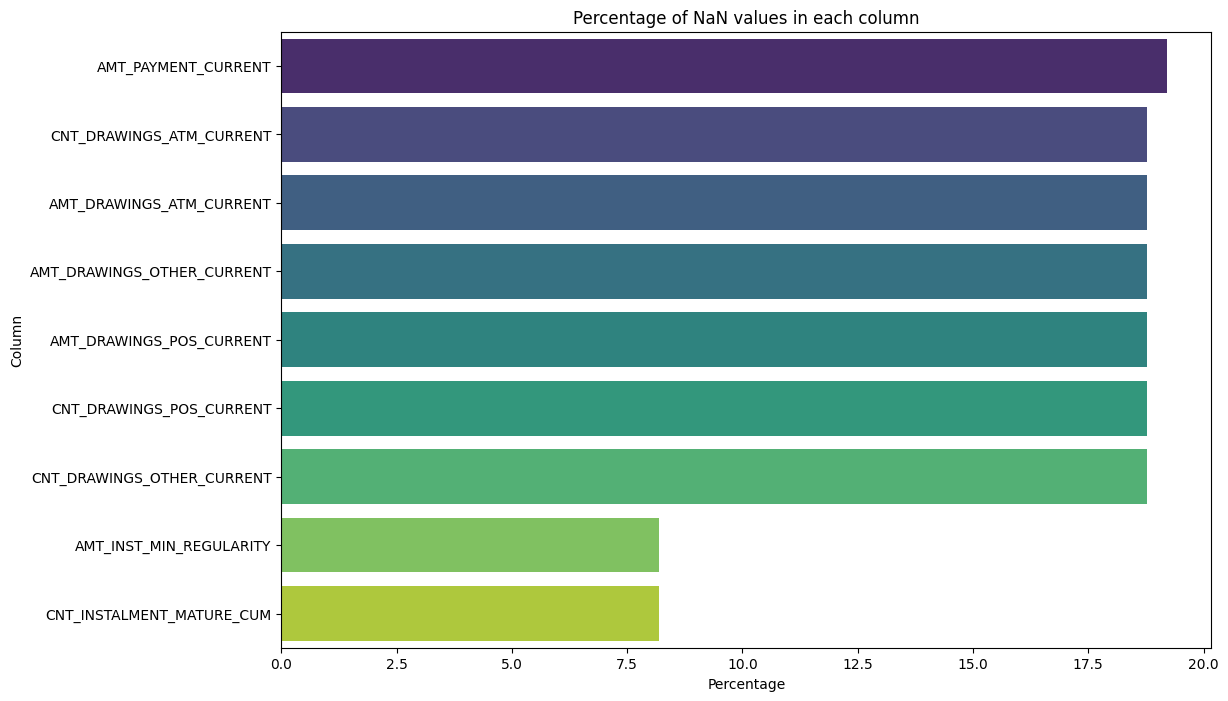

In [15]:
# Create the dataframe of NaN percentages
credit_card_nan = nan_df_create(cc_bal)

# Filter out columns with no NaN values
credit_card_nan = credit_card_nan[credit_card_nan.percent != 0]

# Plot the NaN percentages
plt.figure(figsize=(12, 8))
sns.barplot(x='percent', y='column', data=credit_card_nan, palette='viridis')
plt.title('Percentage of NaN values in each column')
plt.xlabel('Percentage')
plt.ylabel('Column')
plt.show()

In [16]:
cc_bal_merged = pd.merge(cc_bal,train[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')


In [17]:
cc_bal[(cc_bal['AMT_DRAWINGS_ATM_CURRENT'].isna()) & (cc_bal['AMT_DRAWINGS_CURRENT'] != 0)]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR


In [18]:
cc_bal[(cc_bal['AMT_DRAWINGS_OTHER_CURRENT'].isna()) & (cc_bal['AMT_DRAWINGS_CURRENT'] != 0)]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR


In [19]:
cc_bal[(cc_bal['AMT_DRAWINGS_POS_CURRENT'].isna()) & (cc_bal['AMT_DRAWINGS_CURRENT'] != 0)]

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR


- we can see, when AMT_DRAWINGS_ATM_CURRENT has null value, AMT_DRAWINGS_CURRENT always equal to 0. Therefore, we can conclude that person does not draw any amount of money using ATM 
-> Fill 0 for missing value of AMT_DRAWINGS_ATM_CURRENT and CNT_DRAWINGS_ATM_CURRENT
- It's same with AMT_DRAWINGS_OTHER_CURRENT, AMT_DRAWINGS_POS_CURRENT
-> Fill 0 for missing values of AMT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, AMT_DRAWINGS_POS_CURRENT, CNT_DRAWINGS_POS_CURRENT

In [20]:
columns_to_fill = ['AMT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'AMT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT']
cc_bal[columns_to_fill] = cc_bal[columns_to_fill].fillna(0)

# Merge data

In [21]:
cc_bal_merged.head()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR,TARGET
0,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.0,2250.0,...,1.0,1,0.0,0.0,69.0,Active,0,0,87788,1.0
1,2582071,-82,16809.210,67500,0.0,0.0,0.0,0.0,3375.0,9000.0,...,0.0,0,0.0,0.0,18.0,Active,0,0,87788,1.0
2,2582071,-84,27577.890,67500,0.0,0.0,0.0,0.0,3375.0,4500.0,...,0.0,0,0.0,0.0,16.0,Active,0,0,87788,1.0
3,2582071,-7,65159.235,45000,0.0,0.0,0.0,0.0,2250.0,2250.0,...,0.0,0,0.0,0.0,63.0,Active,0,0,87788,1.0
4,2582071,-59,70475.850,67500,24750.0,24750.0,0.0,0.0,3375.0,4500.0,...,4.0,4,0.0,0.0,41.0,Active,0,0,87788,1.0


# Generate features

In [22]:
cc_bal_merged["POSITIVE_CREDIT"] = np.where(cc_bal_merged["AMT_BALANCE"] > 0, 1, 0)

In [ ]:
# rate càng cao thì số tiền trả càng vượt quá số tiền tối thiểu cần trả
cc_bal_merged['RATE_OF_PAYBACK'] = cc_bal_merged['AMT_PAYMENT_TOTAL_CURRENT'] / (cc_bal_merged['AMT_INST_MIN_REGULARITY'] + 1e-6) * (cc_bal_merged['AMT_INST_MIN_REGULARITY']!=0)


In [24]:
cc_bal_merged['SUM_ALL_CNT_DRAWINGS'] = cc_bal_merged['CNT_DRAWINGS_ATM_CURRENT'] + cc_bal_merged['CNT_DRAWINGS_CURRENT'] + cc_bal_merged['CNT_DRAWINGS_OTHER_CURRENT'] + cc_bal_merged['CNT_DRAWINGS_POS_CURRENT']
cc_bal_merged['SUM_ALL_AMT_DRAWINGS'] = cc_bal_merged['AMT_DRAWINGS_ATM_CURRENT'] + cc_bal_merged['AMT_DRAWINGS_CURRENT'] + cc_bal_merged['AMT_DRAWINGS_OTHER_CURRENT'] + cc_bal_merged['AMT_DRAWINGS_POS_CURRENT']

In [25]:
mask = (cc_bal_merged['SUM_ALL_CNT_DRAWINGS'] == 0)
cc_bal_merged.loc[mask, 'RATIO_ALL_AMT_DRAWINGS_TO_ALL_CNT_DRAWINGS'] = np.nan
cc_bal_merged['RATIO_ALL_AMT_DRAWINGS_TO_ALL_CNT_DRAWINGS'] = cc_bal_merged['RATIO_ALL_AMT_DRAWINGS_TO_ALL_CNT_DRAWINGS'].clip(-9, 9)
cc_bal_merged['RATE_OF_PAYBACK'] = cc_bal_merged['RATE_OF_PAYBACK'].clip(-9, 9)

In [26]:
cc_bal_merged["FLAG_6_MONTHS"] = np.where(cc_bal_merged["MONTHS_BALANCE"] >= -6, 1, 0)
cc_bal_merged["FLAG_12_MONTHS"] = np.where(cc_bal_merged["MONTHS_BALANCE"] >= -12, 1, 0)
cc_bal_merged["FLAG_36_MONTHS"] = np.where(cc_bal_merged["MONTHS_BALANCE"] >= -36, 1, 0)

In [27]:
balance_6_months = cc_bal_merged[cc_bal_merged['FLAG_6_MONTHS'] ==1]
balance_12_months = cc_bal_merged[cc_bal_merged['FLAG_12_MONTHS'] ==1]
balance_36_months = cc_bal_merged[cc_bal_merged['FLAG_36_MONTHS'] ==1]

In [28]:
gb_balance_6_months = balance_6_months.groupby('SK_ID_CURR').agg({

    'AMT_PAYMENT_TOTAL_CURRENT': ['sum'],
    'CNT_DRAWINGS_CURRENT' : 'sum',   
    'AMT_DRAWINGS_CURRENT' : ['sum'],
    'RATE_OF_PAYBACK' : ['mean'],
    'AMT_RECEIVABLE_PRINCIPAL' : ['sum'], # SỐ TIỀN GỐC PHẢI THU
    
}).reset_index()

gb_balance_6_months.columns = ['6_MONTH_'+'_'.join(col).strip() for col in gb_balance_6_months.columns.values]
gb_balance_6_months.rename(columns={'6_MONTH_SK_ID_CURR_':'SK_ID_CURR'}, inplace=True)

In [29]:
gb_balance_12_months = balance_12_months.groupby('SK_ID_CURR').agg({

    'AMT_PAYMENT_TOTAL_CURRENT': ['sum'],
    'CNT_DRAWINGS_CURRENT' : 'sum',   
    'AMT_DRAWINGS_CURRENT' : ['sum'],
    'RATE_OF_PAYBACK' : ['mean'],
    'AMT_RECEIVABLE_PRINCIPAL' : ['sum'],
}).reset_index()

gb_balance_12_months.columns = ['12_MONTH_'+'_'.join(col).strip() for col in gb_balance_12_months.columns.values]
gb_balance_12_months.rename(columns={'12_MONTH_SK_ID_CURR_':'SK_ID_CURR'}, inplace=True)

In [30]:
gb_balance_36_months = balance_36_months.groupby('SK_ID_CURR').agg({

    'AMT_PAYMENT_TOTAL_CURRENT': ['sum'],
    'CNT_DRAWINGS_CURRENT' : 'sum',   
    'AMT_DRAWINGS_CURRENT' : ['sum'],
    'RATE_OF_PAYBACK' : ['mean'],
    'AMT_RECEIVABLE_PRINCIPAL' : ['sum'],
}).reset_index()

gb_balance_36_months.columns = ['36_MONTH_'+'_'.join(col).strip() for col in gb_balance_36_months.columns.values]
gb_balance_36_months.rename(columns={'36_MONTH_SK_ID_CURR_':'SK_ID_CURR'}, inplace=True)

In [31]:
cc_bal_merged.head()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,SK_ID_CURR,TARGET,POSITIVE_CREDIT,RATE_OF_PAYBACK,SUM_ALL_CNT_DRAWINGS,SUM_ALL_AMT_DRAWINGS,RATIO_ALL_AMT_DRAWINGS_TO_ALL_CNT_DRAWINGS,FLAG_6_MONTHS,FLAG_12_MONTHS,FLAG_36_MONTHS
0,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.0,2250.0,...,87788,1.0,1,1.000000,2.0,4500.0,NaN,1,1,1
1,2582071,-82,16809.210,67500,0.0,0.0,0.0,0.0,3375.0,9000.0,...,87788,1.0,1,2.666667,0.0,0.0,NaN,0,0,0
2,2582071,-84,27577.890,67500,0.0,0.0,0.0,0.0,3375.0,4500.0,...,87788,1.0,1,1.333333,0.0,0.0,NaN,0,0,0
3,2582071,-7,65159.235,45000,0.0,0.0,0.0,0.0,2250.0,2250.0,...,87788,1.0,1,1.000000,0.0,0.0,NaN,0,1,1
4,2582071,-59,70475.850,67500,24750.0,24750.0,0.0,0.0,3375.0,4500.0,...,87788,1.0,1,1.333333,8.0,49500.0,NaN,0,0,0


In [32]:
cc_bal_merged = pd.merge(cc_bal_merged, gb_balance_6_months, on='SK_ID_CURR', how='left')
cc_bal_merged = pd.merge(cc_bal_merged, gb_balance_12_months, on='SK_ID_CURR', how='left')
cc_bal_merged = pd.merge(cc_bal_merged, gb_balance_36_months, on='SK_ID_CURR', how='left')

In [33]:
cc_bal_merged.columns

Index(['SK_ID_PREV', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF', 'SK_ID_CURR', 'TARGET', 'POSITIVE_CREDIT',
       'RATE_OF_PAYBACK', 'SUM_ALL_CNT_DRAWINGS', 'SUM_ALL_AMT_DRAWINGS',
       'RATIO_ALL_AMT_DRAWINGS_TO_ALL_CNT_DRAWINGS', 'FLAG_6_MONTHS',
       'FLAG_12_MONTHS', 'FLAG_36_MONTHS',
       '6_MONTH_AMT_PAYMENT_TOTAL_CURRENT_sum',
       '6_MONTH_CNT_DRAWINGS_CURRENT_sum', '6_MONTH_AMT_DRAWINGS_CURRENT_sum',
       '6_MONTH_RATE_OF_PAYBACK_mean', '6_MONTH_AMT_RE

# Correlation matrix

In [34]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

----------------------------------------------------------------------------------------------------


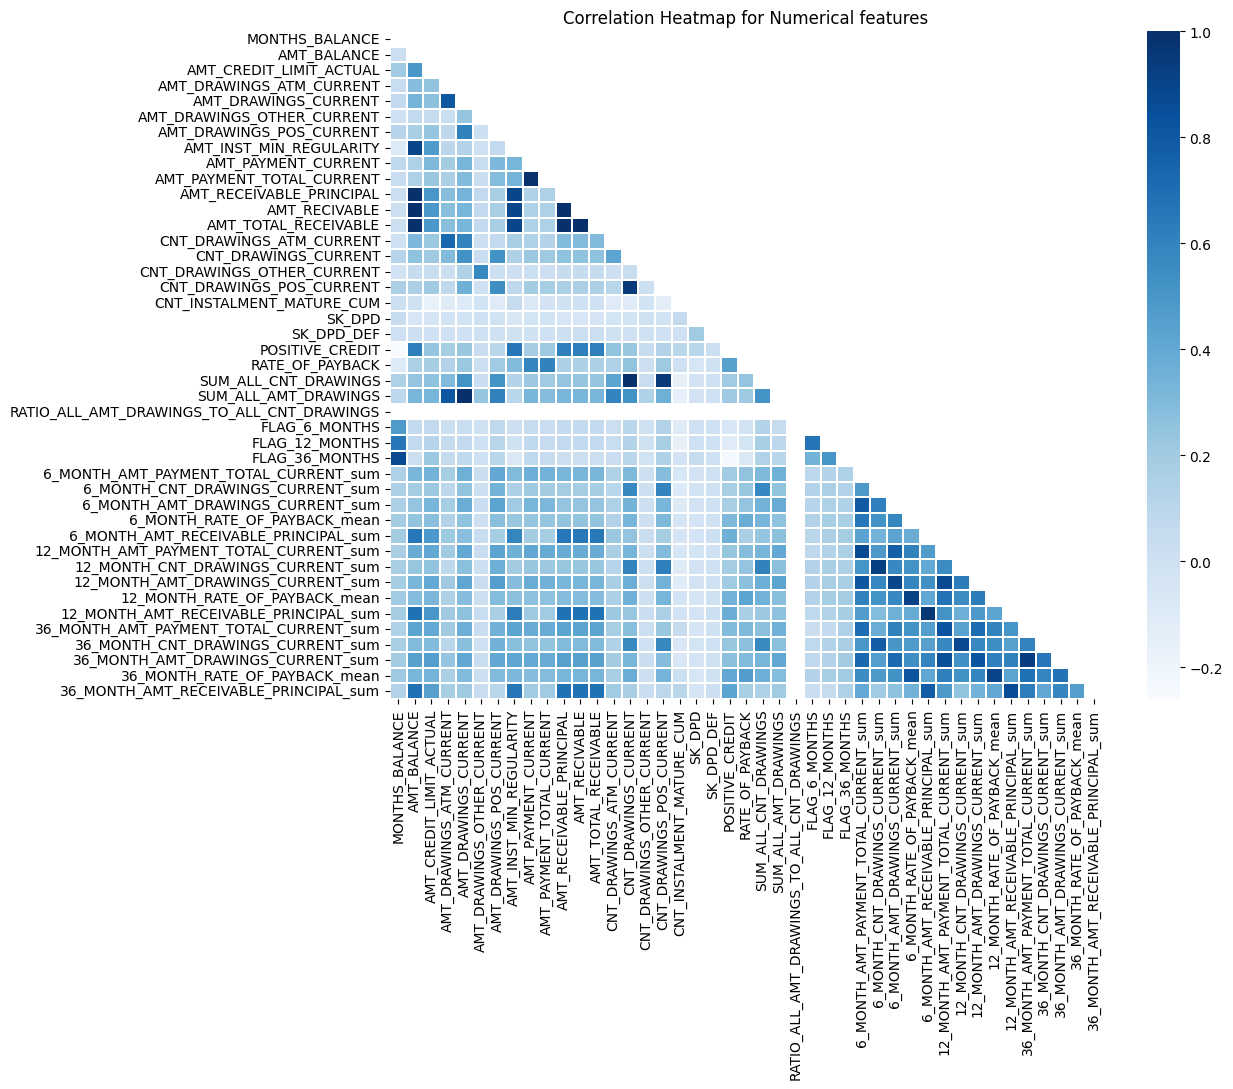

----------------------------------------------------------------------------------------------------


In [35]:
# Drop non-numeric columns
cc_bal_merged_numeric = cc_bal_merged.select_dtypes(include=[np.number])

corr_mat = correlation_matrix(cc_bal_merged_numeric, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

From the heatmap of correlation matrix, we see a few couples of highly correlated features. These are:
- AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE and AMT_BALANCE
- We also observe high correlation between these 3 AMT_RECEIVABLE columns
- AMT_PAYMENT_TOTAL_CURRENT and AMT_PAYMENT_CURRENT


# Categorical variables

In [36]:
cc_bal_merged['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active           3116673
Completed         100031
Signed              9939
Demand               843
Sent proposal        460
Refused               14
Approved               5
Name: count, dtype: int64

<Axes: xlabel='NAME_CONTRACT_STATUS', ylabel='count'>

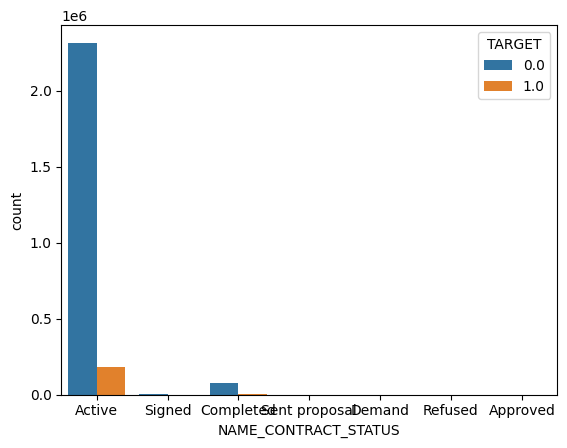

In [37]:
sns.countplot(data=cc_bal_merged,x=cc_bal_merged['NAME_CONTRACT_STATUS'], hue='TARGET' )


In [38]:
def plot_normalized_stacked_bar_chart(data, category_col, binary_col):
    '''
    input: 
        data: dataframe
        category_col: categorycal column
        binary_Col: target column
    '''
    grouped = data.groupby(category_col)[binary_col].value_counts(normalize=True).unstack()
    grouped.plot(kind='bar', stacked=True)
    plt.title('Normalized Stacked Bar Chart')
    plt.xlabel(category_col)
    plt.ylabel('Percentage')
    plt.show()

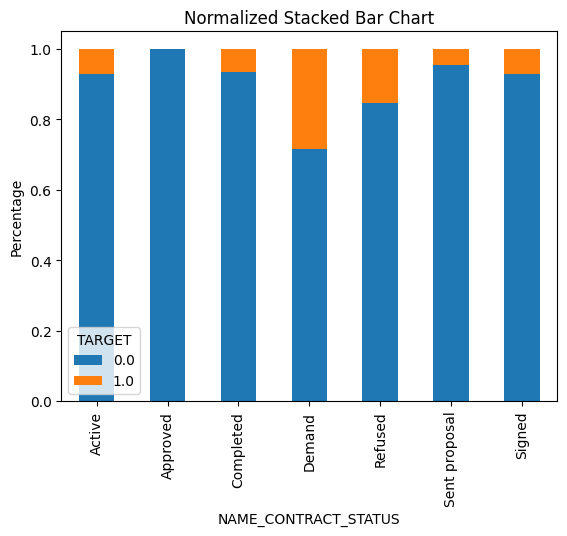

In [39]:
plot_normalized_stacked_bar_chart(cc_bal_merged,"NAME_CONTRACT_STATUS", "TARGET")


Status Active and Completed have less chance of defaulting. Borrowers with active contracts are currently engaged in the loan repayment process. For contracts marked as "completed," the borrower has already successfully fulfilled their loan obligations and repaid the debt in full.

# Numerical vaiables

### function to plot continuous variables

In [40]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='blue')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='red')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

###  kde plot of features from cal_bal

Plotting 18 columns: ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM']


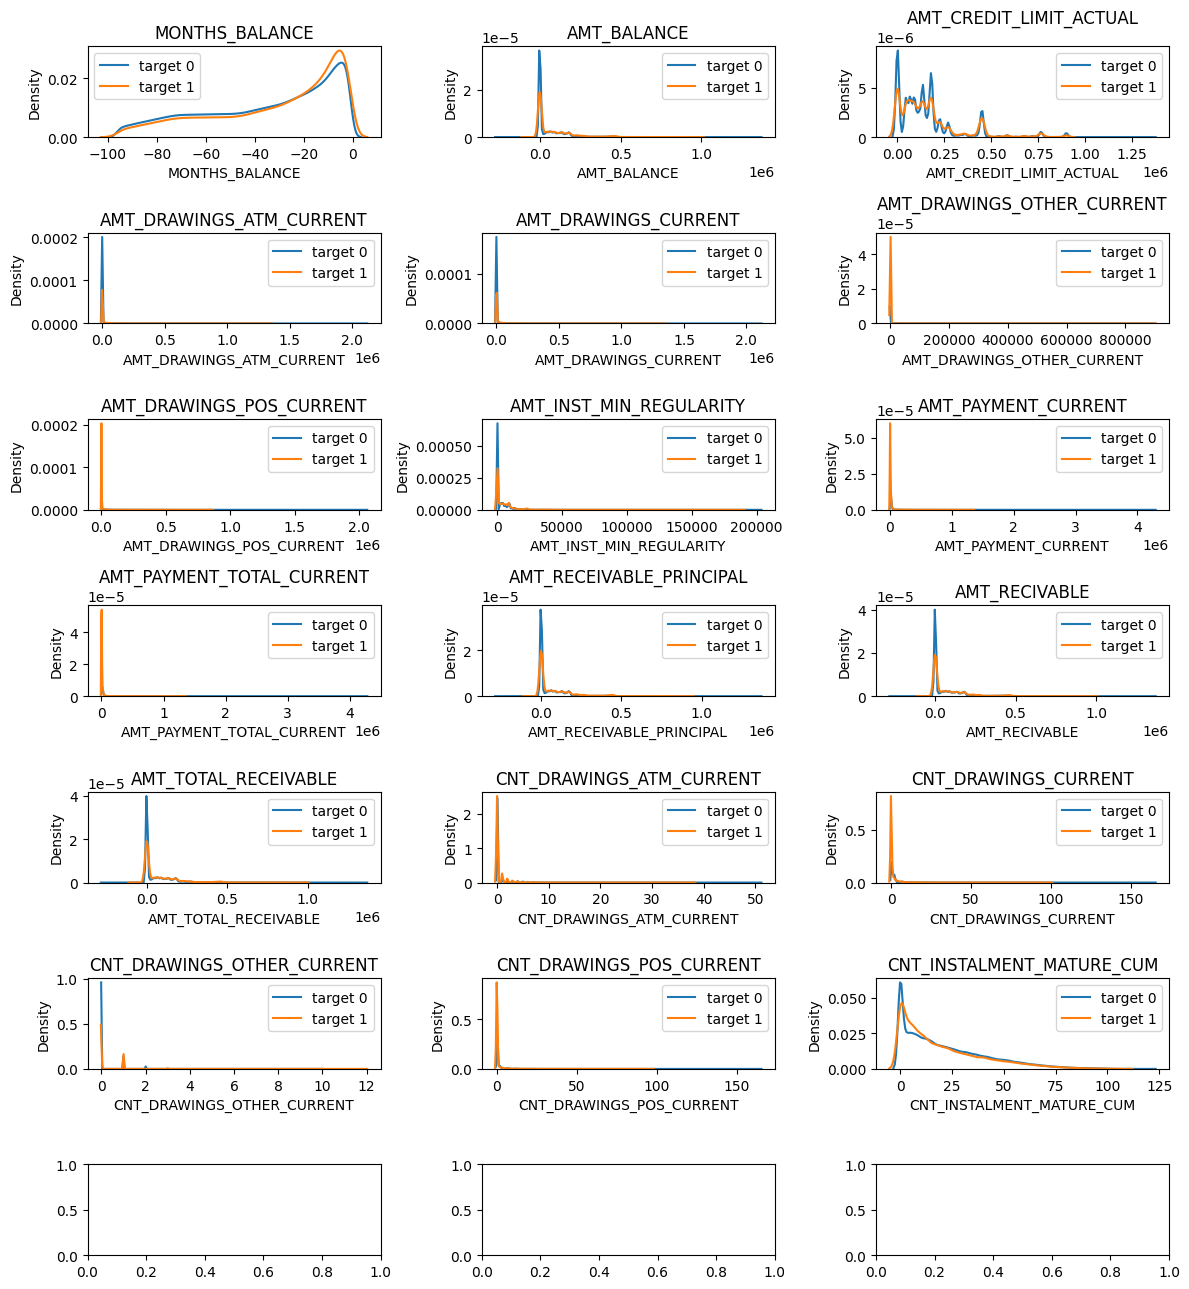

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_plot = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
                'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
                'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT',
                'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
                'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
                'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM']

print(f'Plotting {len(cols_to_plot)} columns: {cols_to_plot}')
ncol, nrow = 3, len(cols_to_plot) // 3 + 1  # Set number of rows and columns
fig, ax = plt.subplots(nrow, ncol, figsize=(12, 6 + nrow))  # Increase the second value for height

# Loop over the columns and plot
for i, col in enumerate(cols_to_plot):
    # kde plot
    sns.kdeplot(cc_bal_merged.loc[cc_bal_merged['TARGET'] == 0, col], label='target 0', ax=ax[i // ncol, i % ncol])
    sns.kdeplot(cc_bal_merged.loc[cc_bal_merged['TARGET'] == 1, col], label='target 1', ax=ax[i // ncol, i % ncol])
    ax[i // ncol, i % ncol].set_title(col)
    ax[i // ncol, i % ncol].legend()

# Adjust layout and spacing
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Increase hspace to add more vertical space between subplots

plt.tight_layout()  # Optional: Make sure everything fits without overlap
plt.show()


Almost features of cc_bal with 2 value 0,1 of TARGET has the same distribution 

## AMT_BALANCE

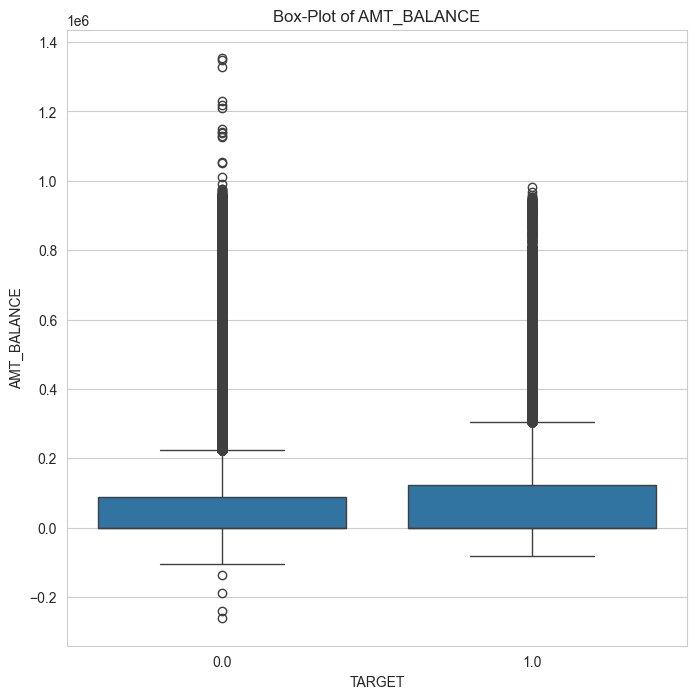

In [43]:
plot_continuous_variables(cc_bal_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))


- The Defaulters have a higher value of AMT_BALANCE as compared to Non-Defaulters


## AMT_TOTAL_RECEIVABLE

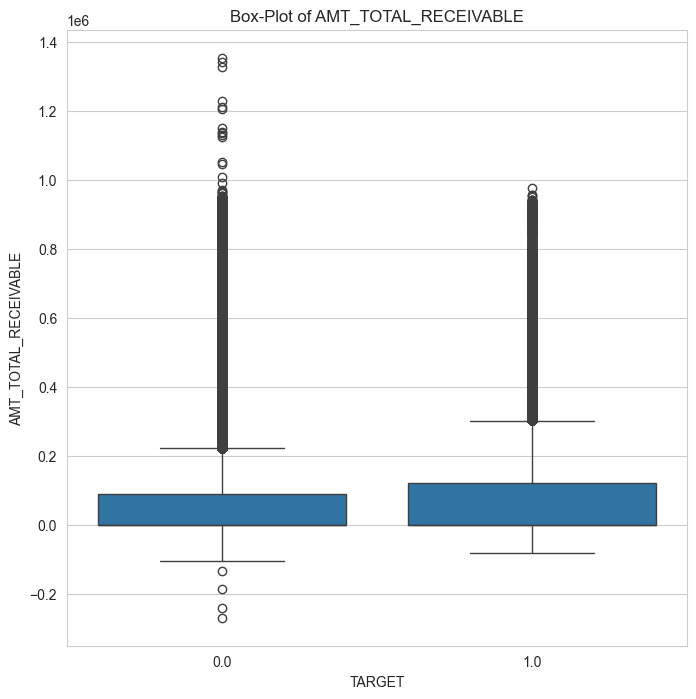

In [44]:
plot_continuous_variables(cc_bal_merged, 'AMT_TOTAL_RECEIVABLE', plots = ['box'], figsize = (8,8))

The Defaulters usually had higher Amount Receivable on their previous credit, which may imply the higher amounts of credits that they may have taken. The PDF also shows a very higher peak at lower amounts for Non-Defaulters as compared to Defaulters.

## SUM_ALL_AMT_DRAWINGS, SUM_ALL_CNT_DRAWINGS

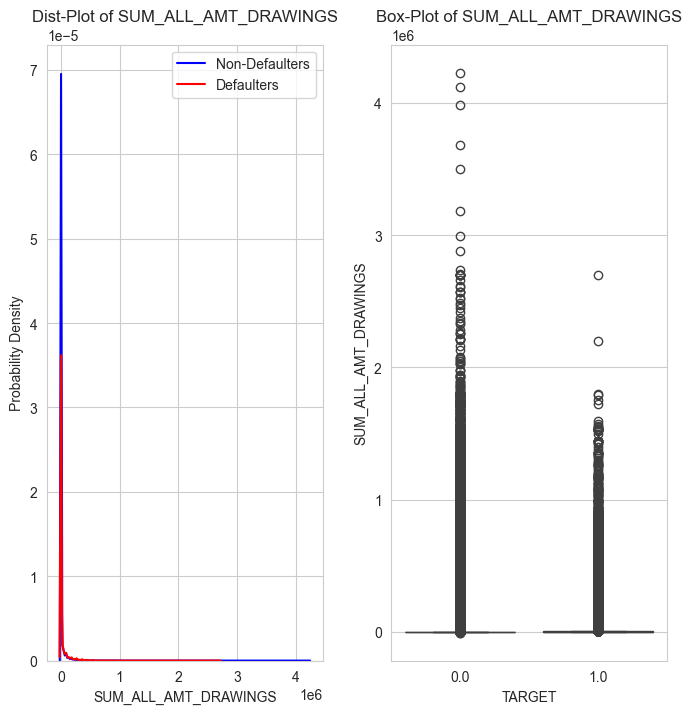

In [45]:
plot_continuous_variables(cc_bal_merged, 'SUM_ALL_AMT_DRAWINGS', plots = ['distplot','box'], figsize = (8,8))

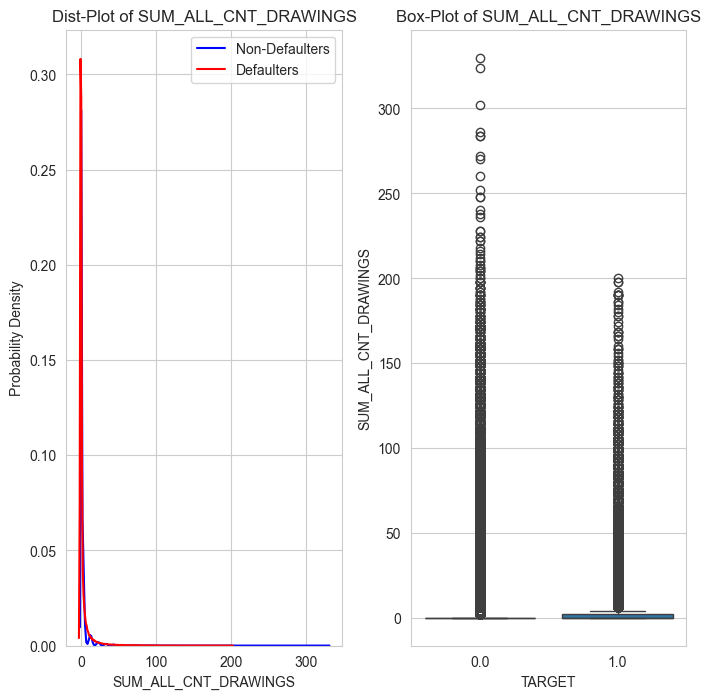

In [46]:
plot_continuous_variables(cc_bal_merged, 'SUM_ALL_CNT_DRAWINGS', plots = ['distplot','box'], figsize = (8,8))

The PDF shows a very higher peak at lower amounts of drawing for Non-Defaulters as compared to Defaulters.

## Excellent credit

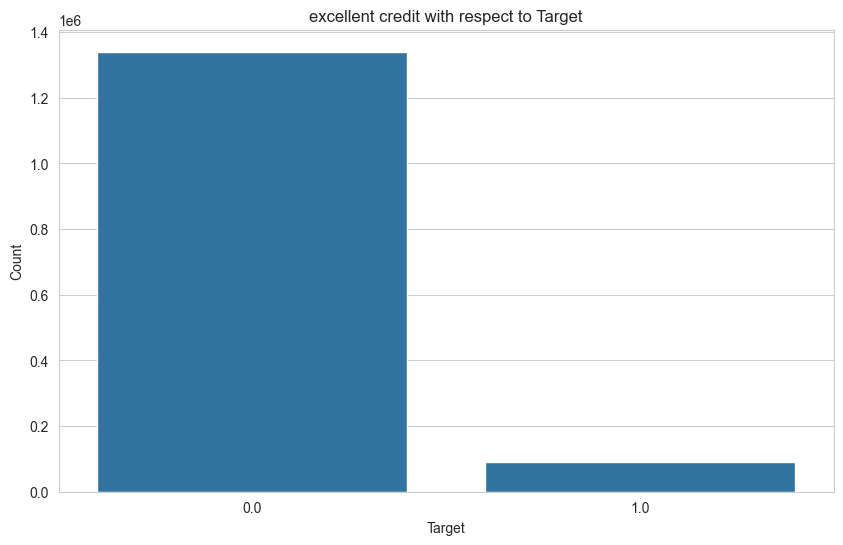

In [47]:
# excellent credit is defined as the customer pay the excess amount of credit in the month
excellent_credit = cc_bal_merged[cc_bal_merged['POSITIVE_CREDIT'] == 0]

# Plot the bar plot
plt.figure(figsize=(10, 6))
sns.countplot(data=excellent_credit, x='TARGET')
plt.title('excellent credit with respect to Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

The non-defaulters tend to have much more excellent credit then the defaulters

## Compare 6 months

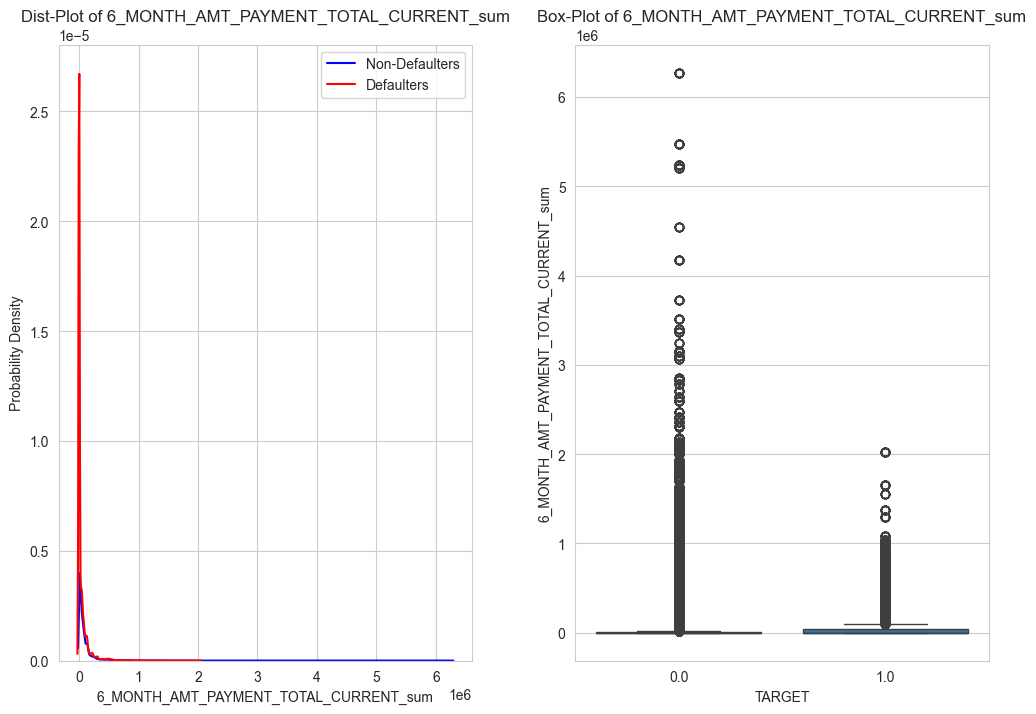

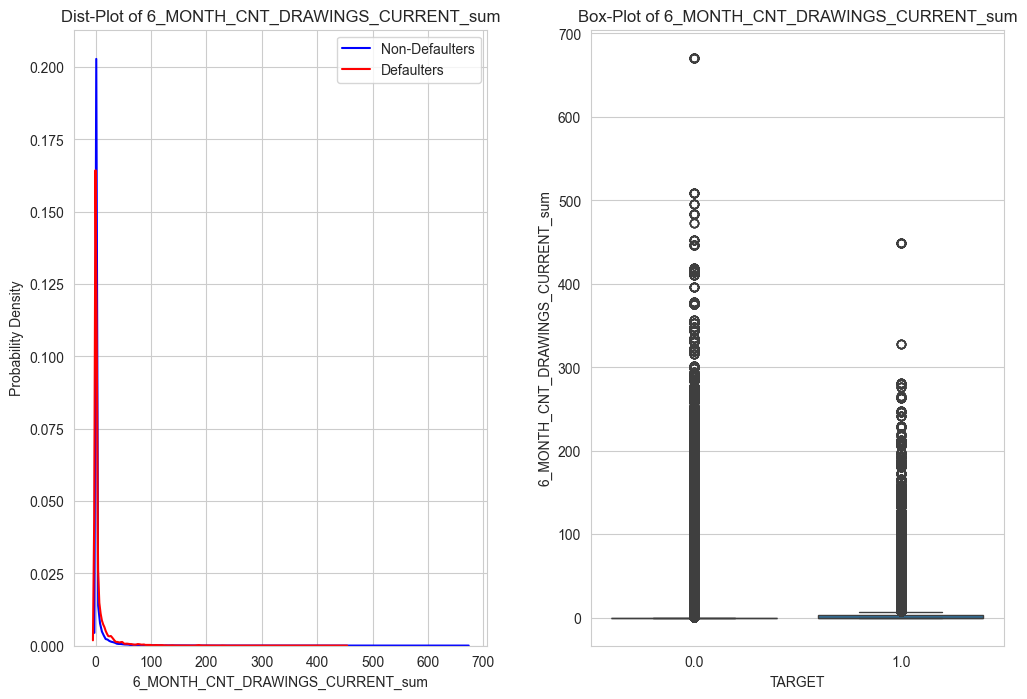

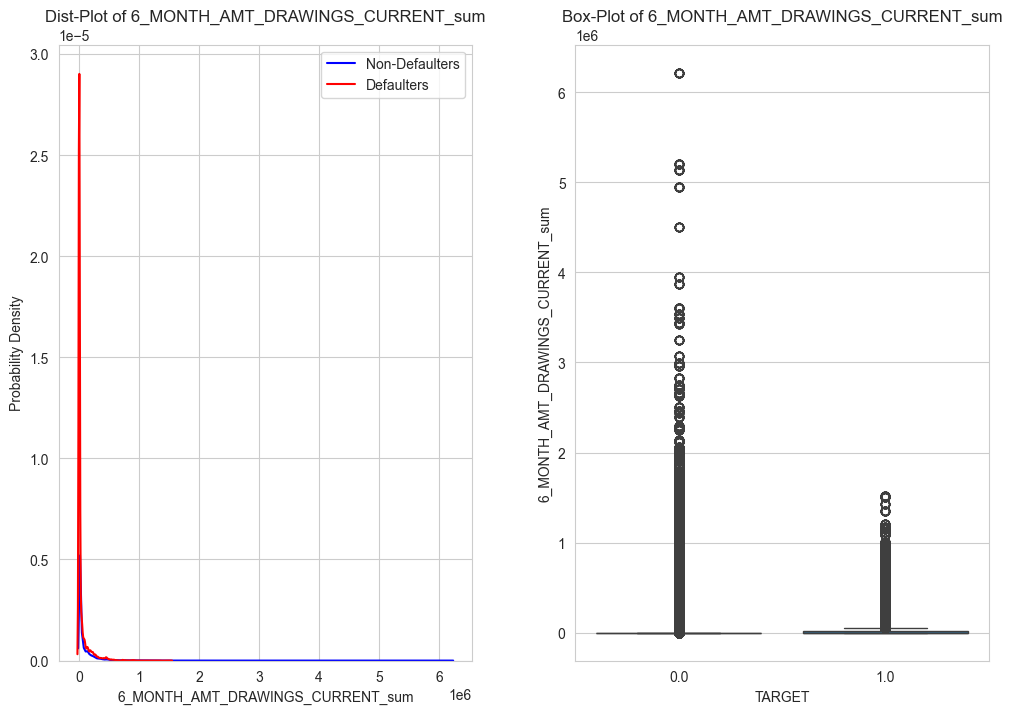

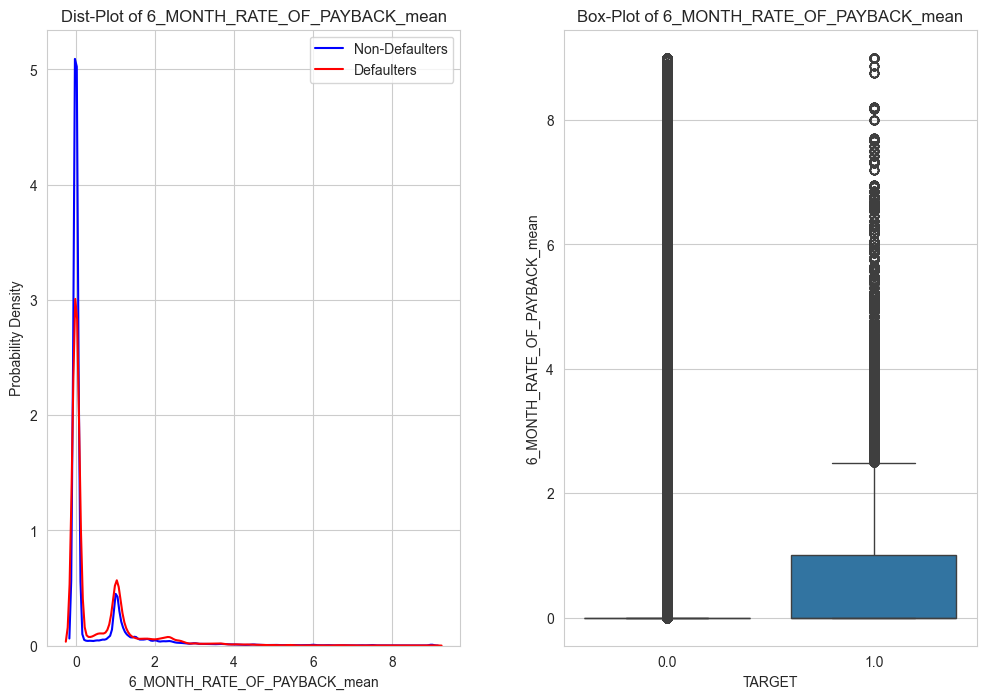

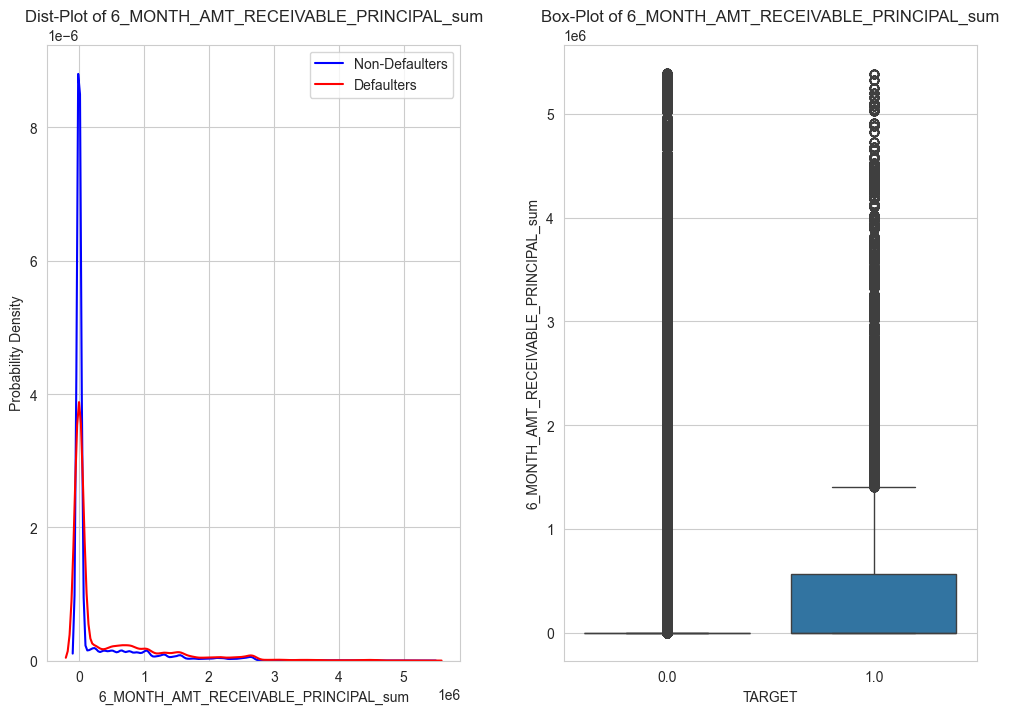

In [50]:
columns_to_plot = ['6_MONTH_AMT_PAYMENT_TOTAL_CURRENT_sum', '6_MONTH_CNT_DRAWINGS_CURRENT_sum', 
                   '6_MONTH_AMT_DRAWINGS_CURRENT_sum', '6_MONTH_RATE_OF_PAYBACK_mean', 
                   '6_MONTH_AMT_RECEIVABLE_PRINCIPAL_sum']

for column in columns_to_plot:
    plot_continuous_variables(cc_bal_merged, column, plots = ['distplot','box'], figsize = (12,8))

- in 6 latest month, the defaulters have higher rate of payback but have larger receivable principal compare to the non-defaulter.
- non-defaulters tend to finish their loan in latest 6 month while defaulters have high amount of receivable principal


## COMPARE 12 MONTHS

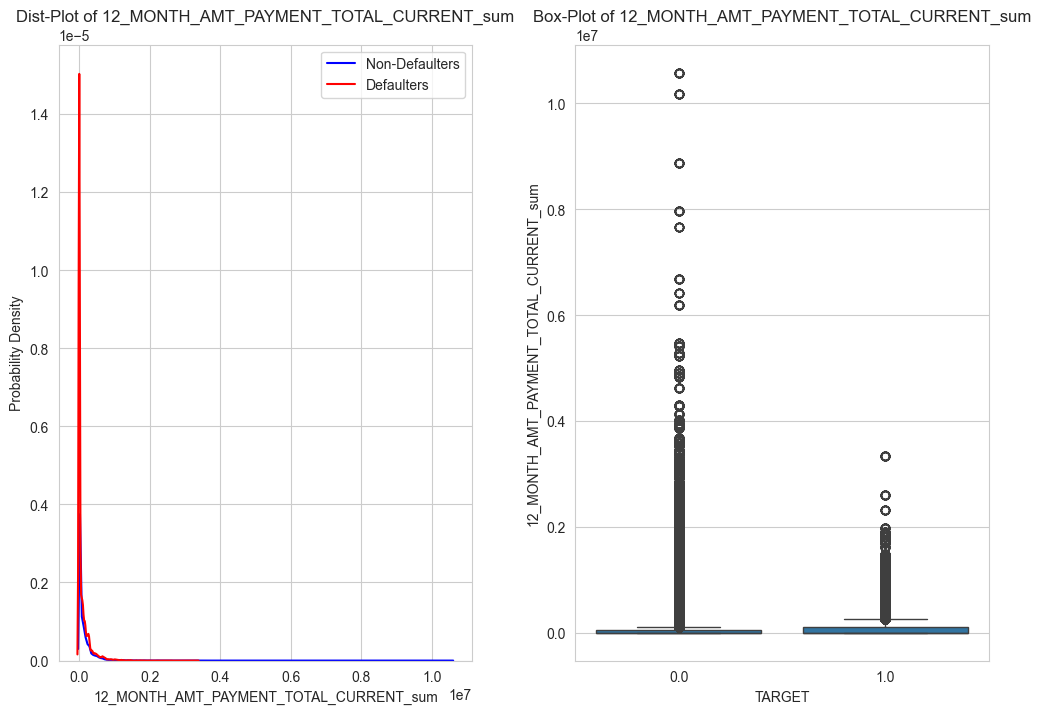

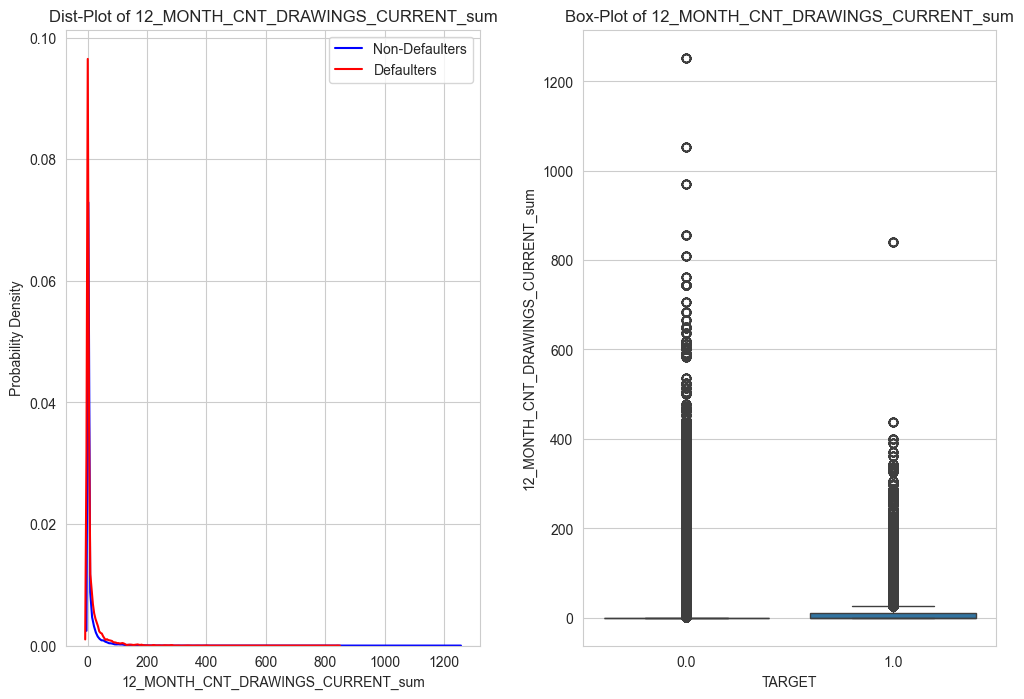

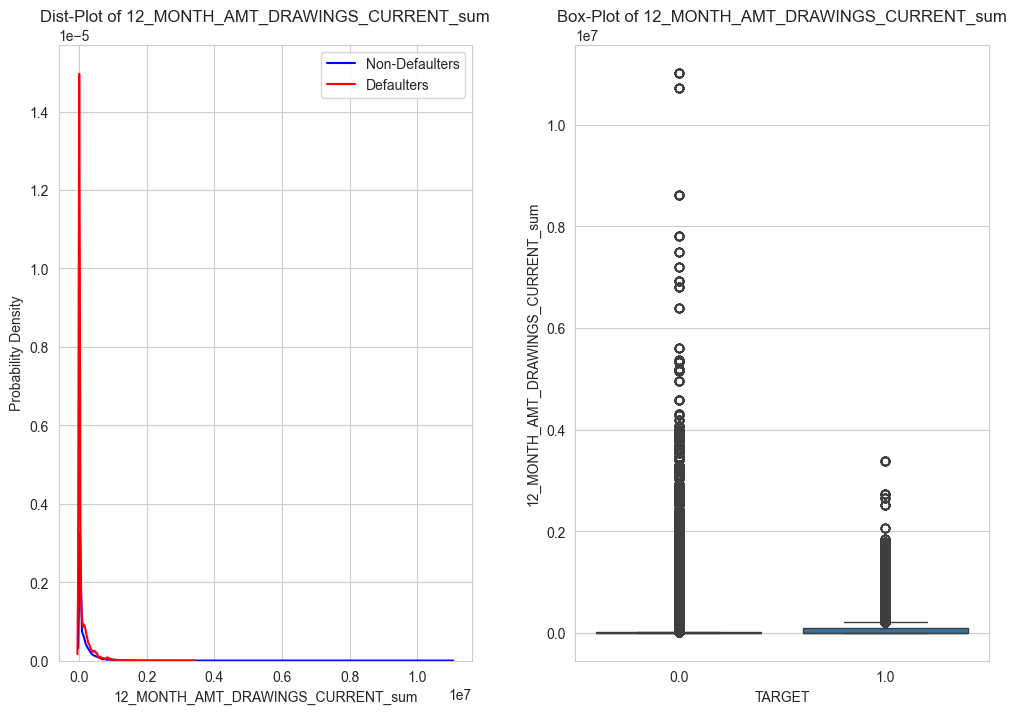

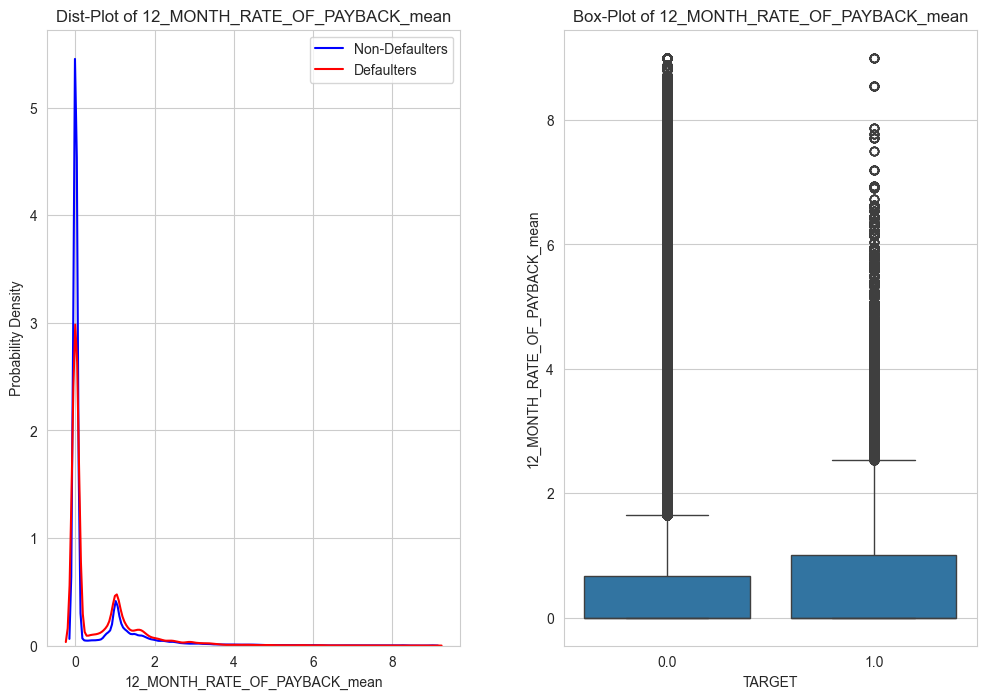

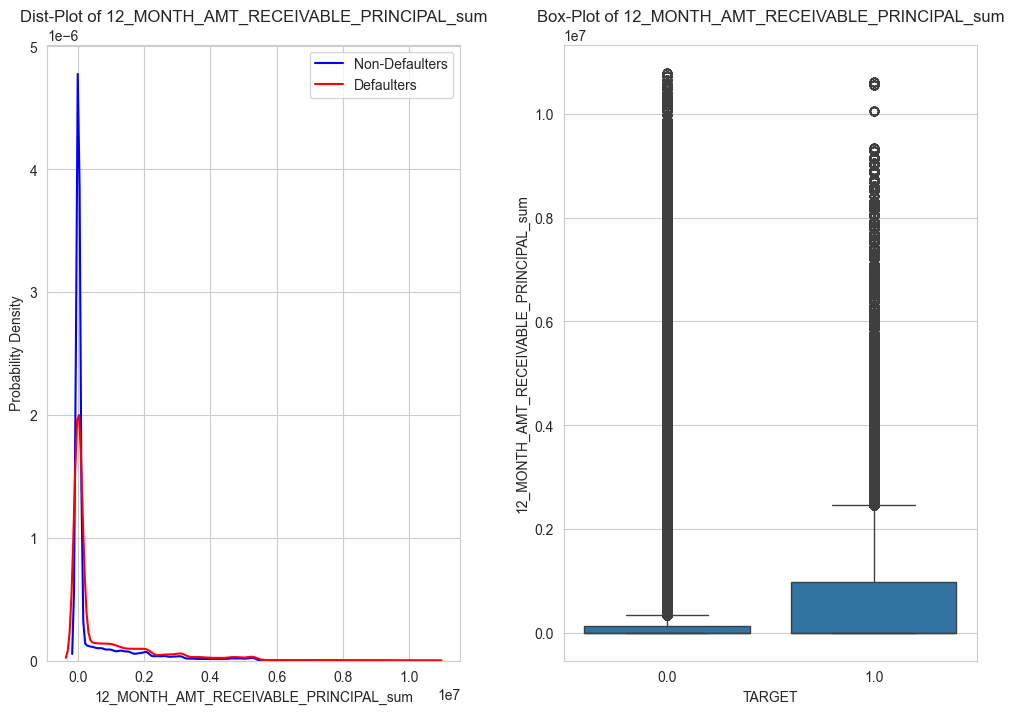

In [51]:
columns_to_plot = ['12_MONTH_AMT_PAYMENT_TOTAL_CURRENT_sum', '12_MONTH_CNT_DRAWINGS_CURRENT_sum', 
                   '12_MONTH_AMT_DRAWINGS_CURRENT_sum', '12_MONTH_RATE_OF_PAYBACK_mean', 
                   '12_MONTH_AMT_RECEIVABLE_PRINCIPAL_sum']

for column in columns_to_plot:
    plot_continuous_variables(cc_bal_merged, column, plots = ['distplot','box'], figsize = (12,8))

in latest 12 months: 
- defaulters have higher amount and times of drawing than non-defaulters.
- defaulters have higher rate of payback, but much larger receivable principal compare to the non-defaulter. We can asumme that defaulters

## compare 36 months

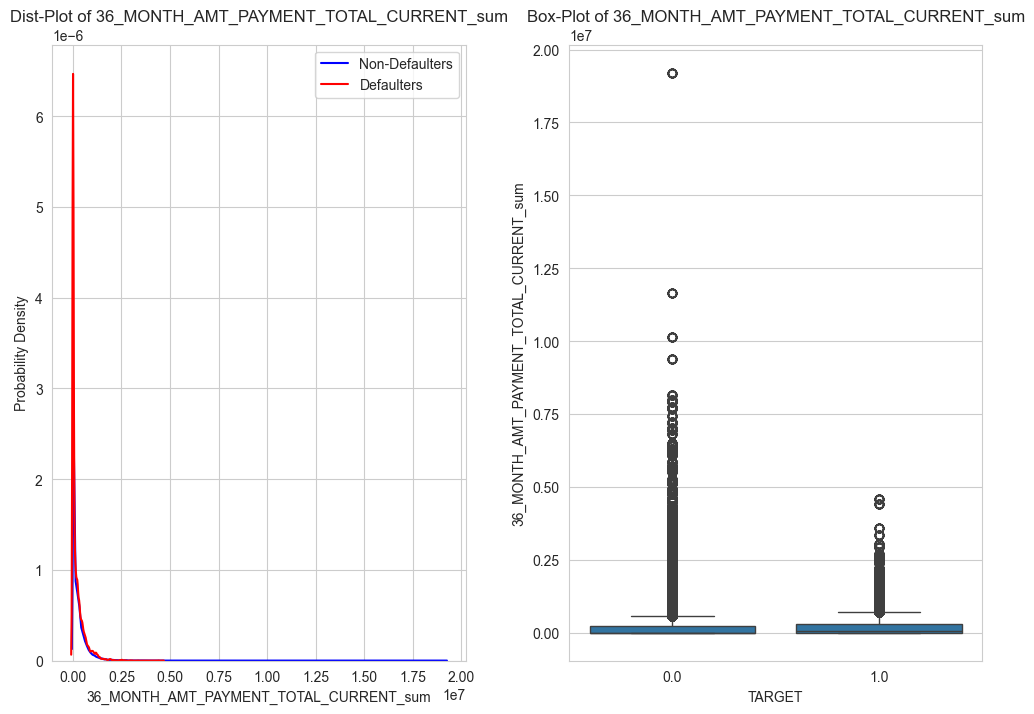

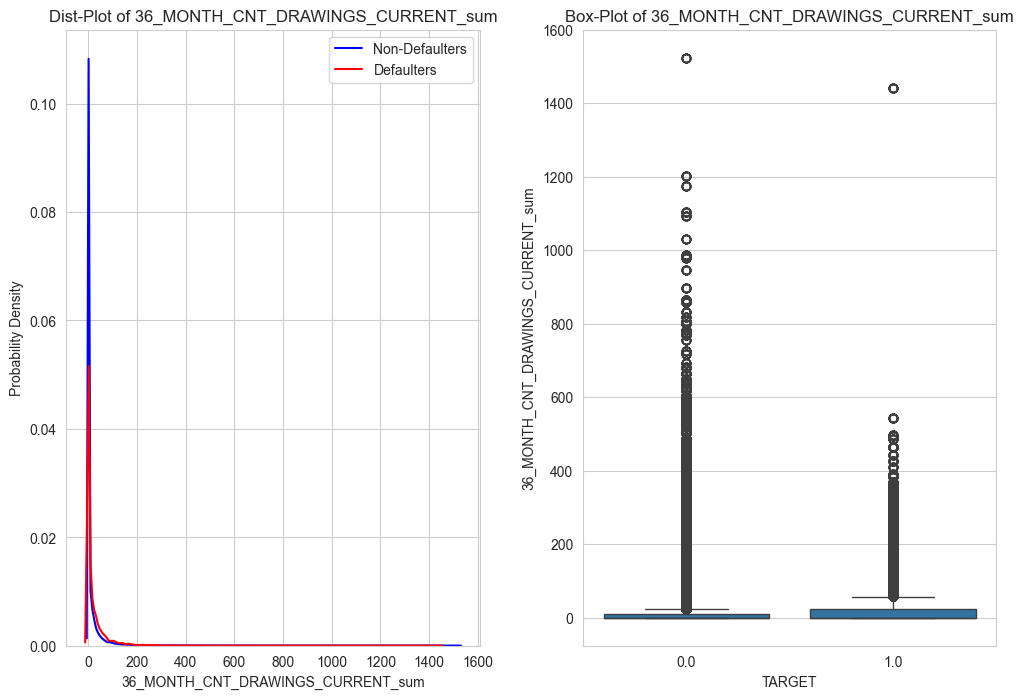

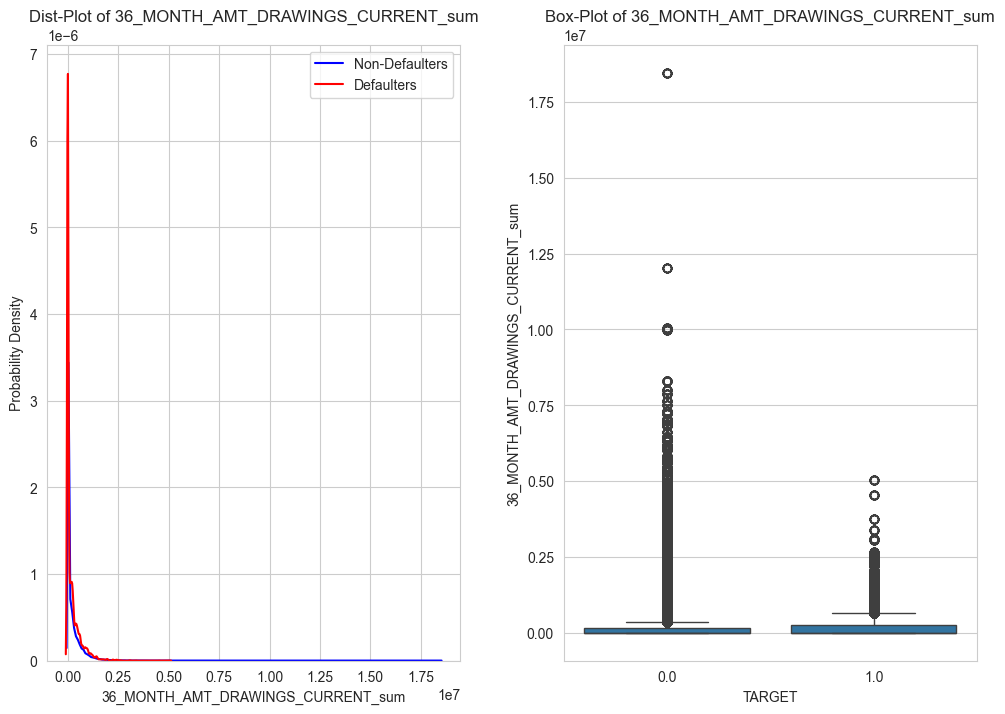

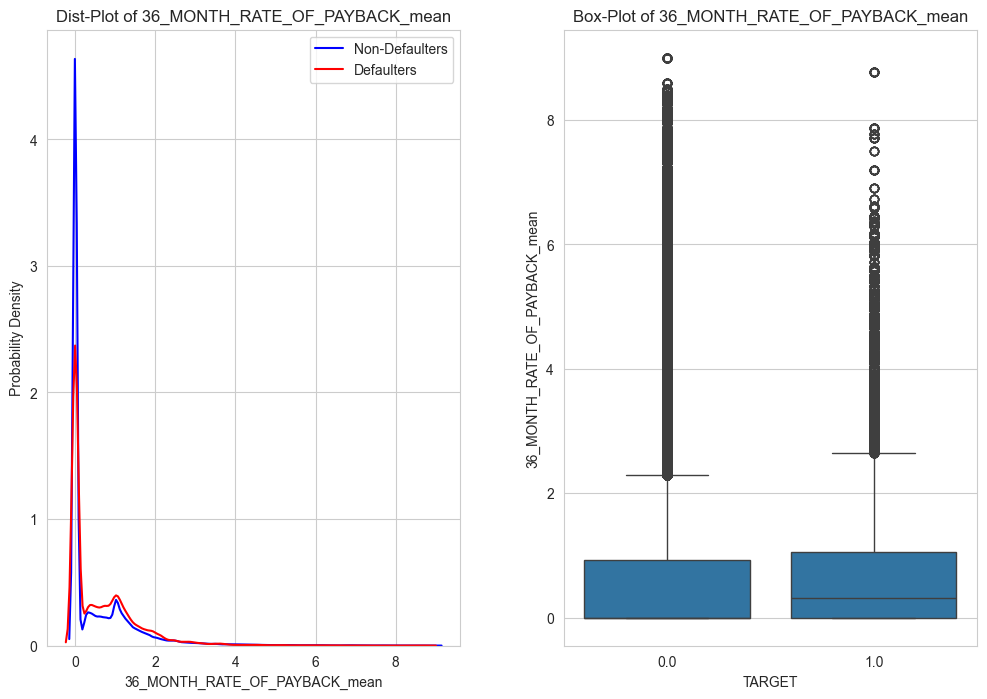

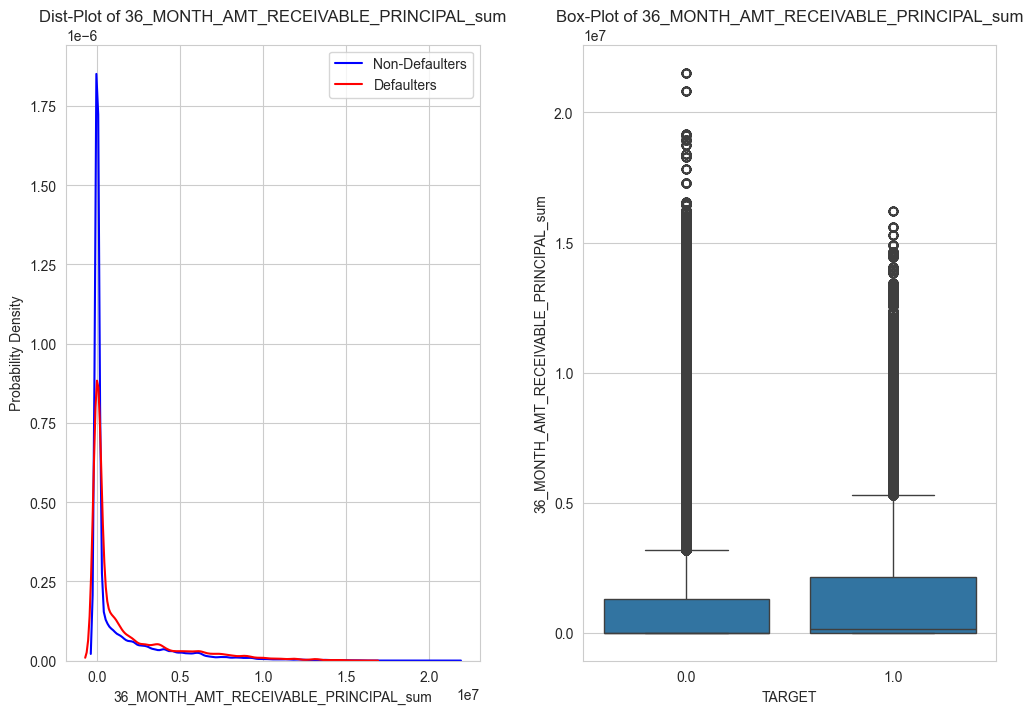

In [52]:
columns_to_plot = ['36_MONTH_AMT_PAYMENT_TOTAL_CURRENT_sum', '36_MONTH_CNT_DRAWINGS_CURRENT_sum', 
                   '36_MONTH_AMT_DRAWINGS_CURRENT_sum', '36_MONTH_RATE_OF_PAYBACK_mean', 
                   '36_MONTH_AMT_RECEIVABLE_PRINCIPAL_sum']

for column in columns_to_plot:
    plot_continuous_variables(cc_bal_merged, column, plots = ['distplot','box'], figsize = (12,8))

In latest 36 months, the defaulters have higher rate of payback and much higher amount of receivable principal. Therefore, we can make the assumption that the defaulters tends to have high amount of credit loan than non-defaulters, and they may delay paying the loan in the previous time. When the date of payments is closer, while non-defaulters tend to already finish their loan, defaulters have large amount of loan to pay. Therefore they have to pay more than the minimal installment for the month during this time. However, the debt is too large so that they can not repay the debt on time.